# Explore here

In [5]:
# Standard library imports
from pathlib import Path

# Third-party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression




In [6]:
# Data Loading and inspection

import pandas as pd

url = pd.read_csv('https://raw.githubusercontent.com/4GeeksAcademy/linear-regression-project-tutorial/main/medical_insurance_cost.csv')
url

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [7]:
df = url
df.head()


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [8]:
# Save that data

Path('../data/raw').mkdir(exist_ok=True, parents=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [9]:
# Data Composition - Interval features

key_features = ['age', 'bmi','children','charges']
df[key_features].describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


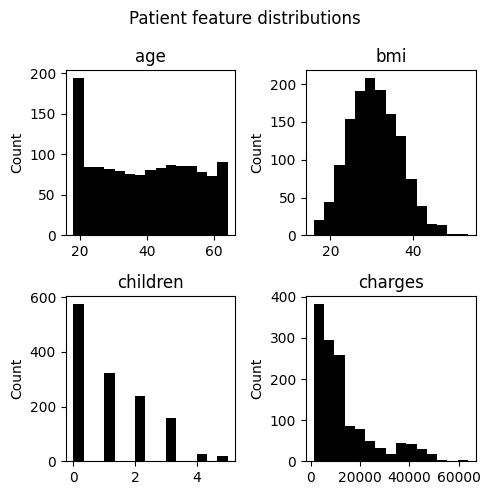

In [10]:
fig, axs = plt.subplots(2,2, figsize=(5,5))
axs = axs.flatten()

fig.suptitle('Patient feature distributions')

for i, feature in enumerate(key_features):
    axs[i].set_title(feature)
    axs[i].hist(df[feature], color='black', bins=15)
    axs[i].set_ylabel('Count')

plt.tight_layout()
plt.show()

In [13]:
# Nominal features
nominal_features = ['sex', 'smoker', 'region']

level_counts = (
    df[nominal_features]
    .melt(var_name='feature', value_name='level')
    .value_counts()
    .reset_index(name='Count')
    .set_index(['feature', 'level'])
)

level_counts


Count
feature level           
smoker  no          1064
sex     male         676
        female       662
region  southeast    364
        northwest    325
        southwest    325
        northeast    324
smoker  yes          274

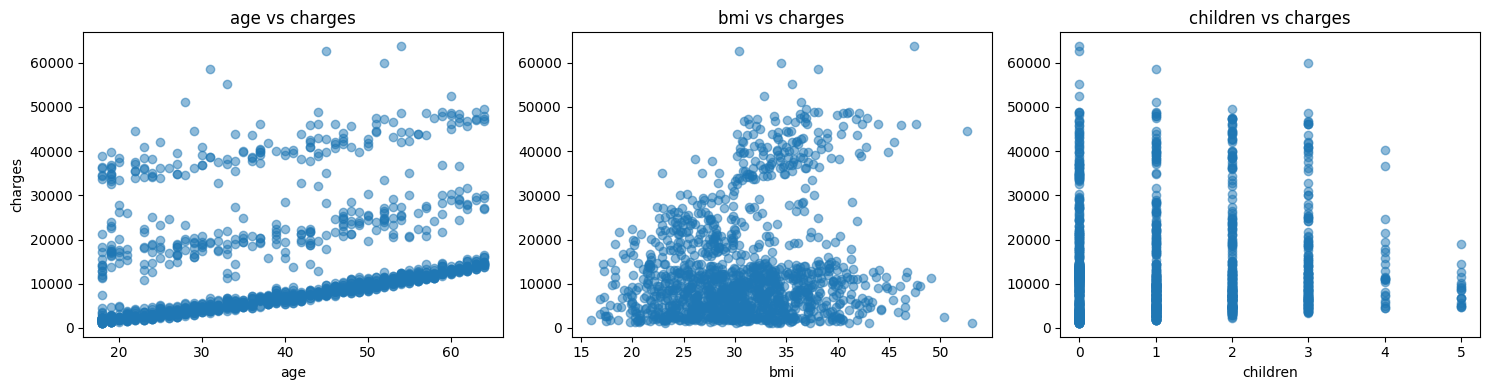

In [21]:
# Feature interactions
# Interval features v labels

key_features = ['age', 'bmi','children']  # numerical features
target = 'charges'

plt.figure(figsize=(15, 4))

for i, feature in enumerate(key_features, 1):
    plt.subplot(1, len(key_features), i)
    plt.scatter(df[feature], df[target], alpha=0.5)
    plt.xlabel(feature)
    plt.ylabel(target if i == 1 else "")
    plt.title(f"{feature} vs {target}")

plt.tight_layout()
plt.show()


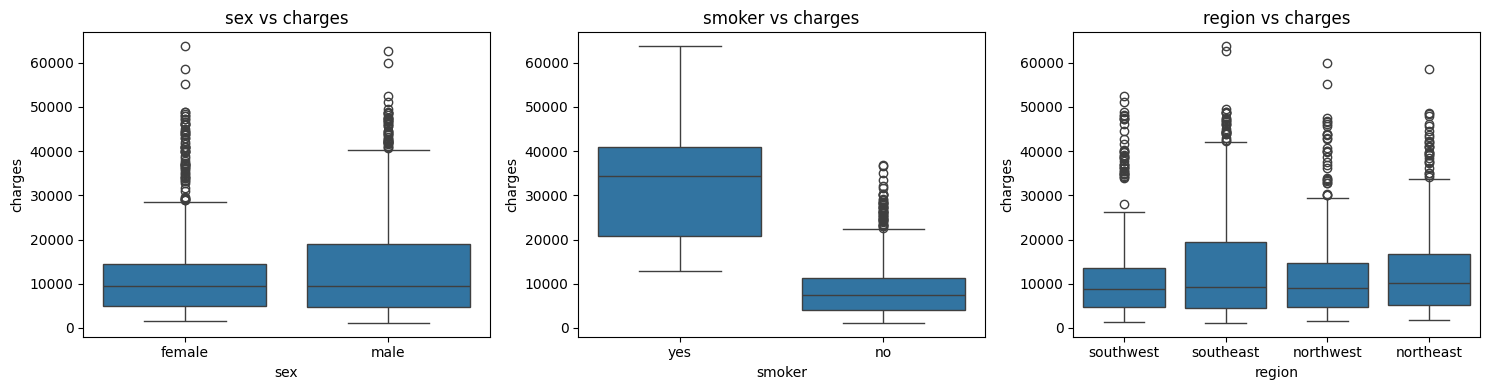

In [24]:
# Nominal Features v Label

plt.figure(figsize=(15, 4))

for i, feature in enumerate(nominal_features, 1):
    plt.subplot(1, len(nominal_features), i)
    sns.boxplot(x=feature, y=target, data=df)
    plt.title(f"{feature} vs {target}")

plt.tight_layout()
plt.show()

In [25]:
# Data Prep
# Train test split

# Separate features (X) and target (y)
X = df.drop(columns='charges')  
y = df['charges']               

# Split data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,      
    random_state=42     
)

print(f"Train set size: {X_train.shape[0]} rows")
print(f"Test set size: {X_test.shape[0]} rows")


Train set size: 1070 rows
Test set size: 268 rows


In [28]:
# Feature Encoding
encoder = OneHotEncoder(drop='first', sparse_output=False)

# 3. Fit encoder on training data
encoder.fit(df[nominal_features])

# 4. Transform training and testing data
train_encoded = encoder.transform(df[nominal_features])
test_encoded = encoder.transform(df[nominal_features])

# 5. Get encoded column names
encoded_cols = encoder.get_feature_names_out(nominal_features)

# 6. Create DataFrames for encoded data
train_encoded_df = pd.DataFrame(train_encoded, columns=encoded_cols, index=df.index)
test_encoded_df = pd.DataFrame(test_encoded, columns=encoded_cols, index=df.index)

# 7. Replace nominal features with encoded columns
training_df = pd.concat([df.drop(columns=nominal_features), train_encoded_df], axis=1)
testing_df = pd.concat([df.drop(columns=nominal_features), test_encoded_df], axis=1)

training_df.head()


,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,0.0,1.0,0.0,0.0,1.0
1,18,33.770,1,1725.55230,1.0,0.0,0.0,1.0,0.0
2,28,33.000,3,4449.46200,1.0,0.0,0.0,1.0,0.0
3,33,22.705,0,21984.47061,1.0,0.0,1.0,0.0,0.0
4,32,28.880,0,3866.85520,1.0,0.0,1.0,0.0,0.0


In [29]:
# Model Training

# Store
results = {
    'RMSE': {},
    'R2': {}
}

# Baseline (make it easy, any useful model should significantly out perform it)

# Calculate averages
avg_southeast_smoker = df[(df['smoker'] == 'yes') & (df['region'] == 'southeast')]['charges'].mean()
avg_other = df[~((df['smoker'] == 'yes') & (df['region'] == 'southeast'))]['charges'].mean()

# Baseline prediction function
def baseline_prediction(row):
    if row['smoker'] == 'yes' and row['region'] == 'southeast':
        return avg_southeast_smoker
    else:
        return avg_other

# Apply baseline to test data
df['baseline_pred'] = df.apply(baseline_prediction, axis=1)

# Check baseline performance
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

mse = mean_squared_error(df['charges'], df['baseline_pred'])
rmse = np.sqrt(mse)
r2 = r2_score(df['charges'], df['baseline_pred'])

print(f"Baseline RMSE: {rmse:,.2f}")
print(f"Baseline R²: {r2:.4f}")


Baseline RMSE: 10,610.16
Baseline R²: 0.2318


In [30]:
# Train a default linear regression model on the training data

y_train = training_df['charges']
X_train = training_df.drop(columns='charges')

y_test = testing_df['charges']
X_test = testing_df.drop(columns='charges')

# Create and train the model
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# Predictions
y_pred = lin_reg.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Linear Regression RMSE: {rmse:,.2f}")
print(f"Linear Regression R²: {r2:.4f}")


Linear Regression RMSE: 6,041.68
Linear Regression R²: 0.7509


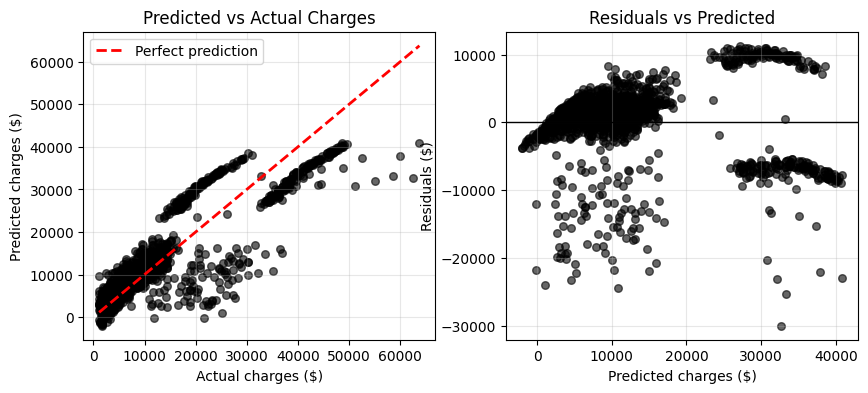

In [31]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Predicted vs Actual
axs[0].scatter(y_test, y_pred, color='black', alpha=0.6, s=30)
axs[0].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 
            'r--', linewidth=2, label='Perfect prediction')
axs[0].set_xlabel('Actual charges ($)')
axs[0].set_ylabel('Predicted charges ($)')
axs[0].set_title('Predicted vs Actual Charges')
axs[0].legend()
axs[0].grid(alpha=0.3)

# Residuals plot
residuals = y_pred - y_test
axs[1].scatter(y_pred, residuals, color='black', alpha=0.6, s=30)
axs[1].axhline(y=0, color='black', linestyle='-', linewidth=1)
axs[1].set_xlabel('Predicted charges ($)')
axs[1].set_ylabel('Residuals ($)')
axs[1].set_title('Residuals vs Predicted')
axs[1].grid(alpha=0.3)